# <font color='steelblue'> Does silencing the cingulate cortex during a test run leads to performance impairments? (timeouts removed)
    
### I will repeat the performance analysis, now with after the removal of trials in which the rat did not express his choice before 15 seconds have elapsed from the start of the trial. During test illumination, the silencing of CG ends after 15 seconds after the illumination started. Therefore, we will only keep in our analysis the trials in which the rat expressed his choice during the first 15 seconds of the run, discarding the ones in which he did not (timeout trials).
    
### Furthermore, I will remove trials in which the sample run was not fully illuminated - in which the rat did not reach the reward port before 15 seconds have elapsed.   
    
### To determine whether the rat has expressed his choice before the 15 seconds has elapsed, we will calculate the latency until exiting the choice point ROI. 
    
#### Then, I will use this metric to remove the timeout trials and re-do our main performance analysis.
#### 5. Performance given experience within experimental groups;
#### 6. Performance given experience within illumination conditions.

### <font color='firebrick'> Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import re
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from file_lists import get_file_list
%matplotlib inline
%run data_prep_functions.ipynb

### <font color='firebrick'> Input

In [2]:
path = "E:\POSITION DATA\PRE PROCESSED"

### <font color= 'seagreen'> Collect the pruned timestamped position and CP rois from all rats in the given path

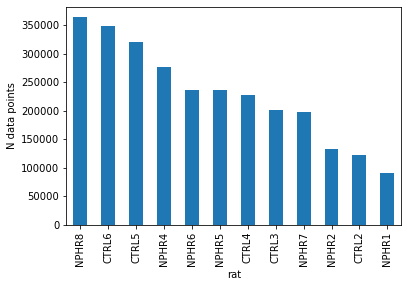

In [3]:
data, cp_rois = collect_pruned_position_and_cp_rois_all_rats_in_path(path)
# Check if data from all rats are present in the dataframe
data['rat'].value_counts().plot.bar()
plt.xlabel('rat')
plt.ylabel('N data points')
plt.show()

### <font color='seagreen'> Collect only the data from test runs

In [4]:
test_runs_raw=data[data['run_type'] == 'T']
test_runs_raw['stim_condition'] =  test_runs_raw['stim_condition'].astype(int)
test_runs_raw=test_runs_raw[(test_runs_raw['stim_condition'] == 0) | (test_runs_raw['stim_condition'] == 3)]
test_runs_raw.head()
len(test_runs_raw)

<ipython-input-4-06522ec3f765>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_runs_raw['stim_condition'] =  test_runs_raw['stim_condition'].astype(int)


727859

### <font color='seagreen'> Get ROI crossing timestamps: start of run, entry in cp, exit of cp and calculate the latency to CP exit

In [5]:
test_runs = get_roi_crossing_timestamps_for_runs_in_df(test_runs_raw, cp_rois)
test_runs['latency_to_cp_exit'] = test_runs['cp_exit_timestamp'] - test_runs['start_timestamp']
test_runs.head(3)

,session,rat,run_nr,start_timestamp,run_type,stim_condition,outcome,group,cp_entry_timestamp,cp_exit_timestamp,latency_to_cp_exit
0,2019-08-08T12_41_07,NPHR1,10.0,751.518003,T,3,1.0,NPHR,755.435469,756.431386,4.913382
1,2019-08-08T12_41_07,NPHR1,14.0,954.084992,T,3,0.0,NPHR,957.866982,958.900954,4.815962
2,2019-08-08T12_41_07,NPHR1,16.0,1018.530202,T,0,1.0,NPHR,1045.142451,1046.004096,27.473894


### <font color='seagreen'> Remove runs without an expressed choice before 15 secs from the start have elapsed 

In [6]:
below15_test_runs = test_runs[test_runs['latency_to_cp_exit']<15]
below15_test_runs.head(3)

,session,rat,run_nr,start_timestamp,run_type,stim_condition,outcome,group,cp_entry_timestamp,cp_exit_timestamp,latency_to_cp_exit
0,2019-08-08T12_41_07,NPHR1,10.0,751.518003,T,3,1.0,NPHR,755.435469,756.431386,4.913382
1,2019-08-08T12_41_07,NPHR1,14.0,954.084992,T,3,0.0,NPHR,957.866982,958.900954,4.815962
3,2019-08-08T12_41_07,NPHR1,18.0,1151.446016,T,0,1.0,NPHR,1153.832614,1154.563149,3.117133


In [7]:
print('Proportion of kept runs (below 15sec until CP exit):{}'.format(len(below15_test_runs)/len(test_runs)))
below_runs_count = below15_test_runs.groupby(['group', 'stim_condition'])['run_nr'].count()
all_runs_count = test_runs.groupby(['group', 'stim_condition'])['run_nr'].count().rename({'run_nr':'all'})

Proportion of kept runs (below 15sec until CP exit):0.9205834683954619


<AxesSubplot:xlabel='group', ylabel='run_nr'>

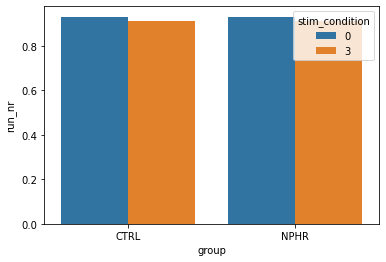

In [8]:
prop_kept_runs = below_runs_count/all_runs_count
sns.barplot(data=prop_kept_runs.reset_index(), x='group', hue='stim_condition', y='run_nr')

In [73]:
# Calculate performances for each rat, session and stimulation condition
session_perfs = below15_test_runs.groupby(['group','rat','session', 'stim_condition']).apply(calc_performance_in_group)
session_perfs = session_perfs.reset_index().rename(columns={0:'performance'})

# <font color='darkgreen'> 1. Does silencing the CG during the test runs leads to performance impairments across the protocol?
***
   #### Calculation of the overall performance for each rat given the stimulation condition and the experimental group
   #### Compares the performance levels of each experimental group under each stimulation condition, across the protocol
***

In [10]:
pooled_perfs = session_perfs.groupby(['group', 'rat', 'stim_condition'])['performance'].mean().reset_index()
pooled_perfs.head(3)

,group,rat,stim_condition,performance
0,CTRL,CTRL2,0,79.553571
1,CTRL,CTRL2,3,80.688808
2,CTRL,CTRL3,0,81.851852


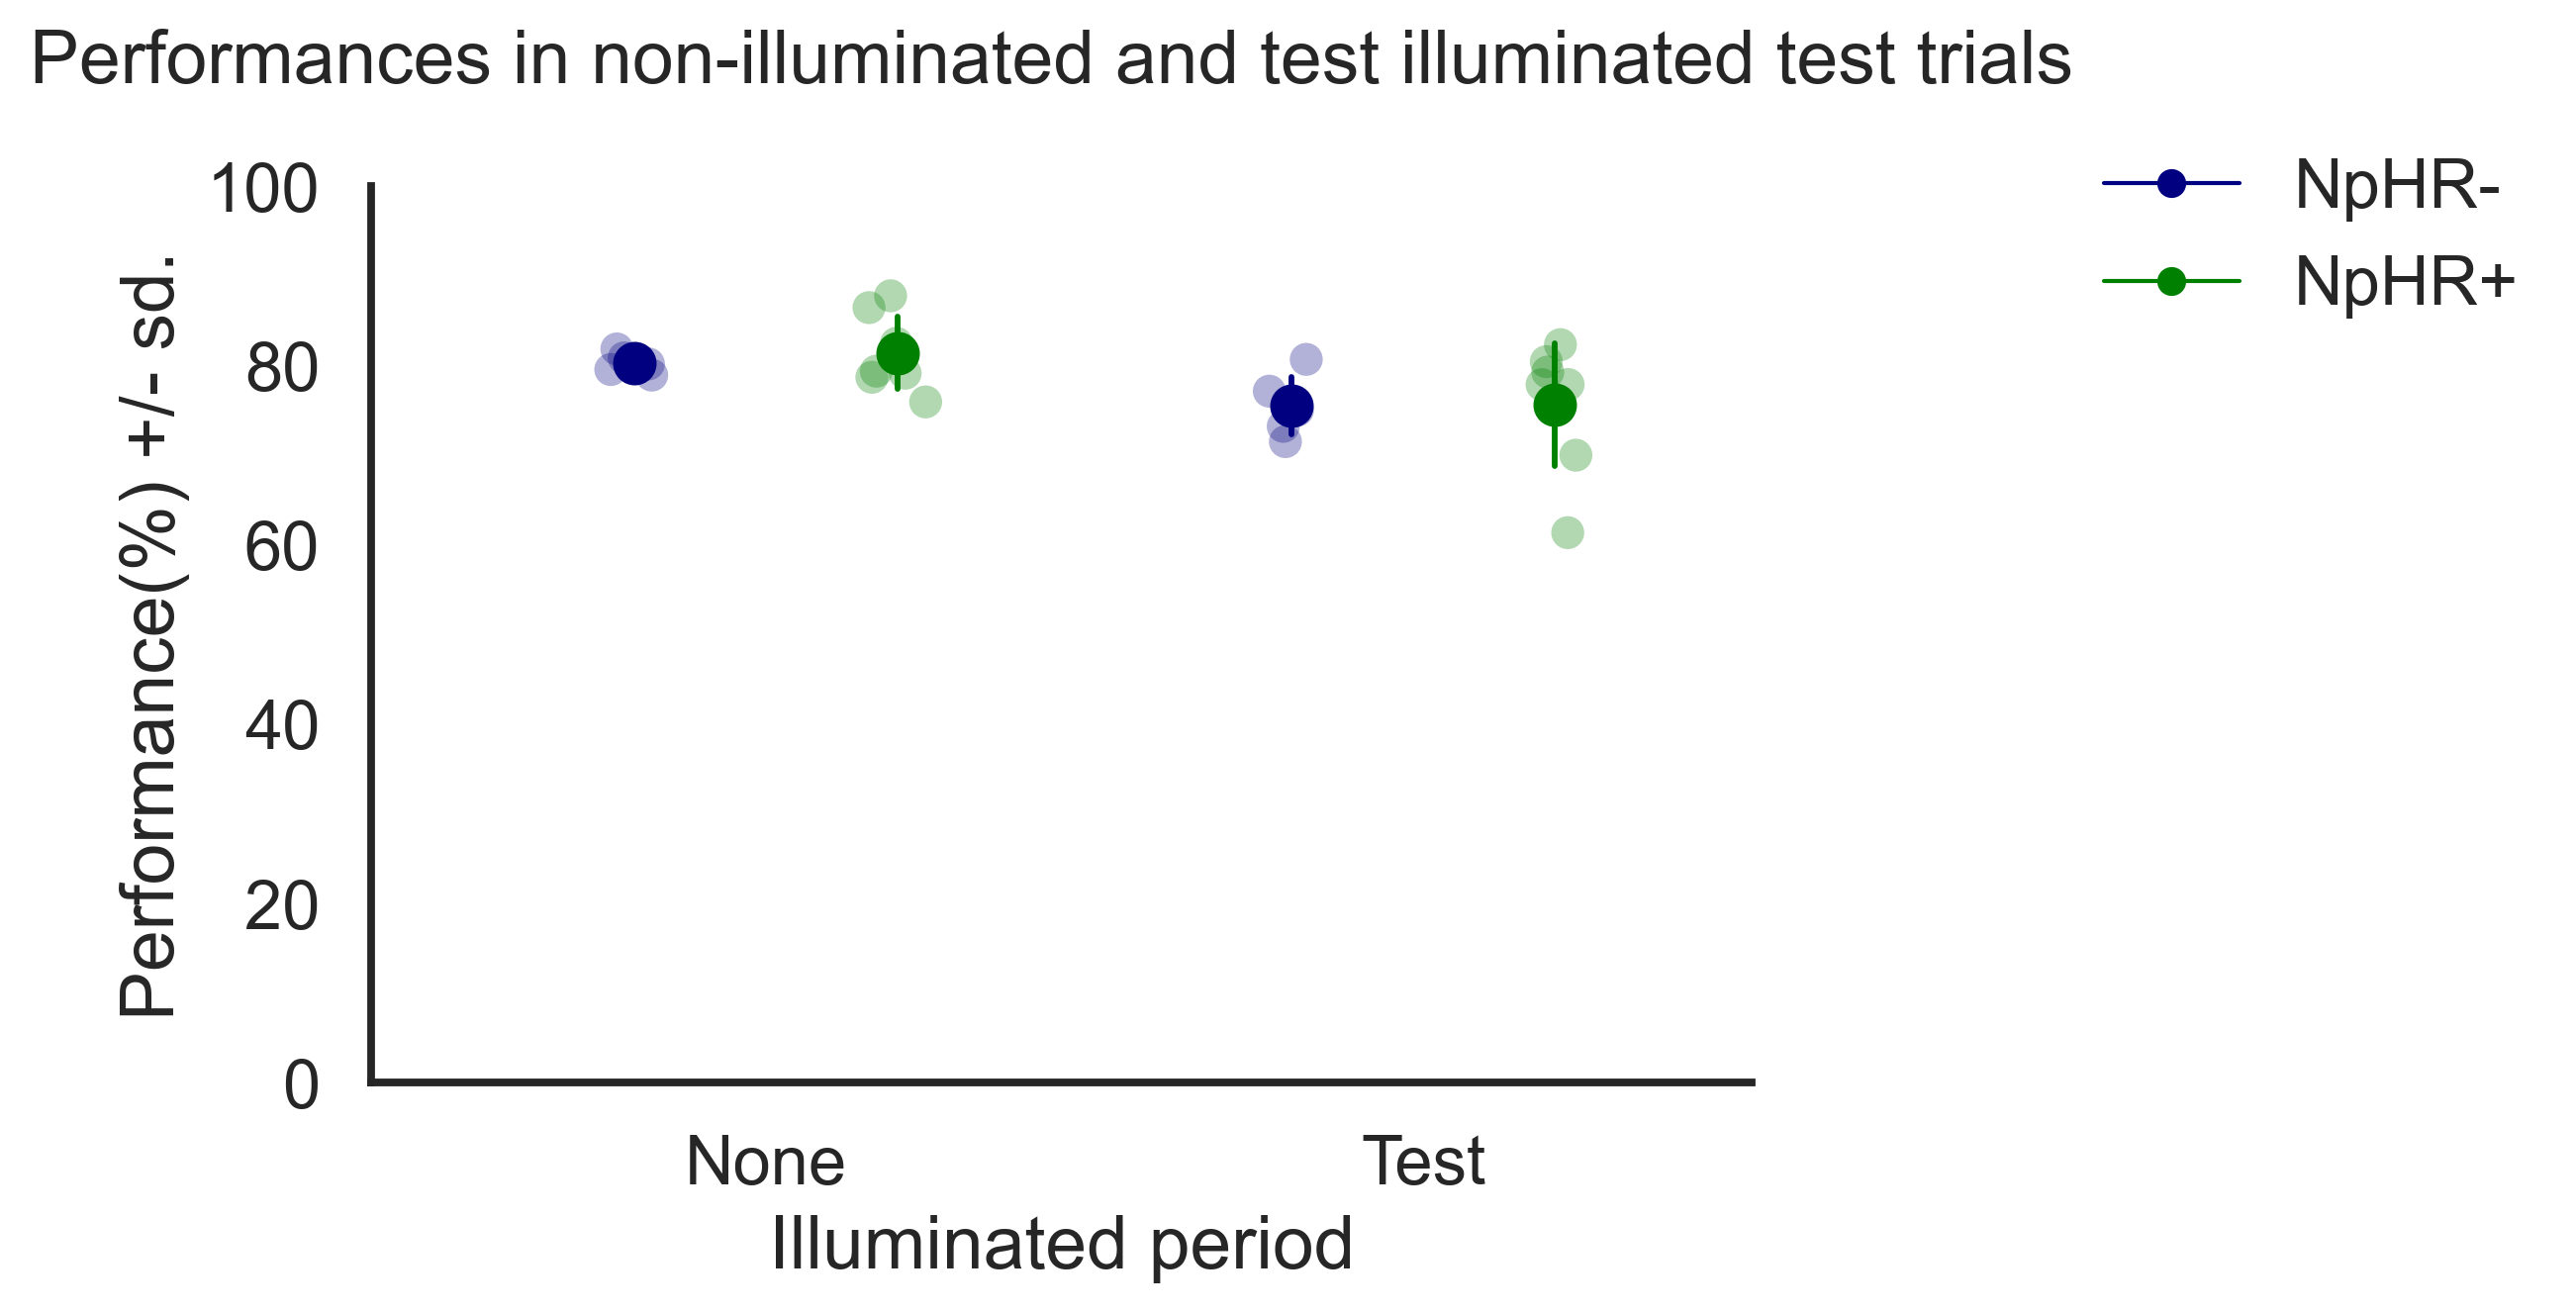

In [11]:
sns.set(style="white", context='talk')    
plt.figure(figsize=(6,4),dpi=300)

pooled_perfs['stim_condition'] = pooled_perfs['stim_condition'].astype(str)

g = sns.stripplot(
    x='stim_condition', y='performance', hue='group',
    data=pooled_perfs,
    dodge=2, jitter=.09,
    alpha=.3, s=8,
    palette=['navy', 'green'],
    order=['0', '3']
)

# Show means
sns.pointplot(
    x='stim_condition', y='performance', hue='group',
    data=pooled_perfs,
    dodge=.4, 
    join=False,            
    markers="o", scale=.8,
    ci="sd", errwidth=1.4,
    palette=['navy', 'green'],
    order=['0', '3']
)

g.set(
    ylabel='Performance(%) +/- sd.', xlabel='Illuminated period',
    ylim=(0, 100), xlim=(-0.6, 1.5),
    title='Performances in non-illuminated and test illuminated test trials \n'
)

g.set_xticklabels(labels=['None', 'Test'], rotation=0)

# ------------------------------------- LEGEND -------------------------------------------- 
g.legend_.remove()

control_line = mlines.Line2D([], [], color='navy', marker='o', markersize=6, linewidth=1, label='NpHR-')
nphr_line = mlines.Line2D([], [], color='green', marker='o', markersize=6, linewidth=1, label='NpHR+')
plt.legend(handles=[control_line, nphr_line], frameon=False, loc='upper right', bbox_to_anchor=(1.6, 1.1))
sns.despine()

### When comparing the NpHR- and the NpHR+ group, under similar illumination condition (No illumination and Test illumination), we find that, on average, the group performance is not distinct. To better compare the performance within each group under different illumination conditions, we will plot the experimental groups on the xx axis, using the illumination condition as hue.

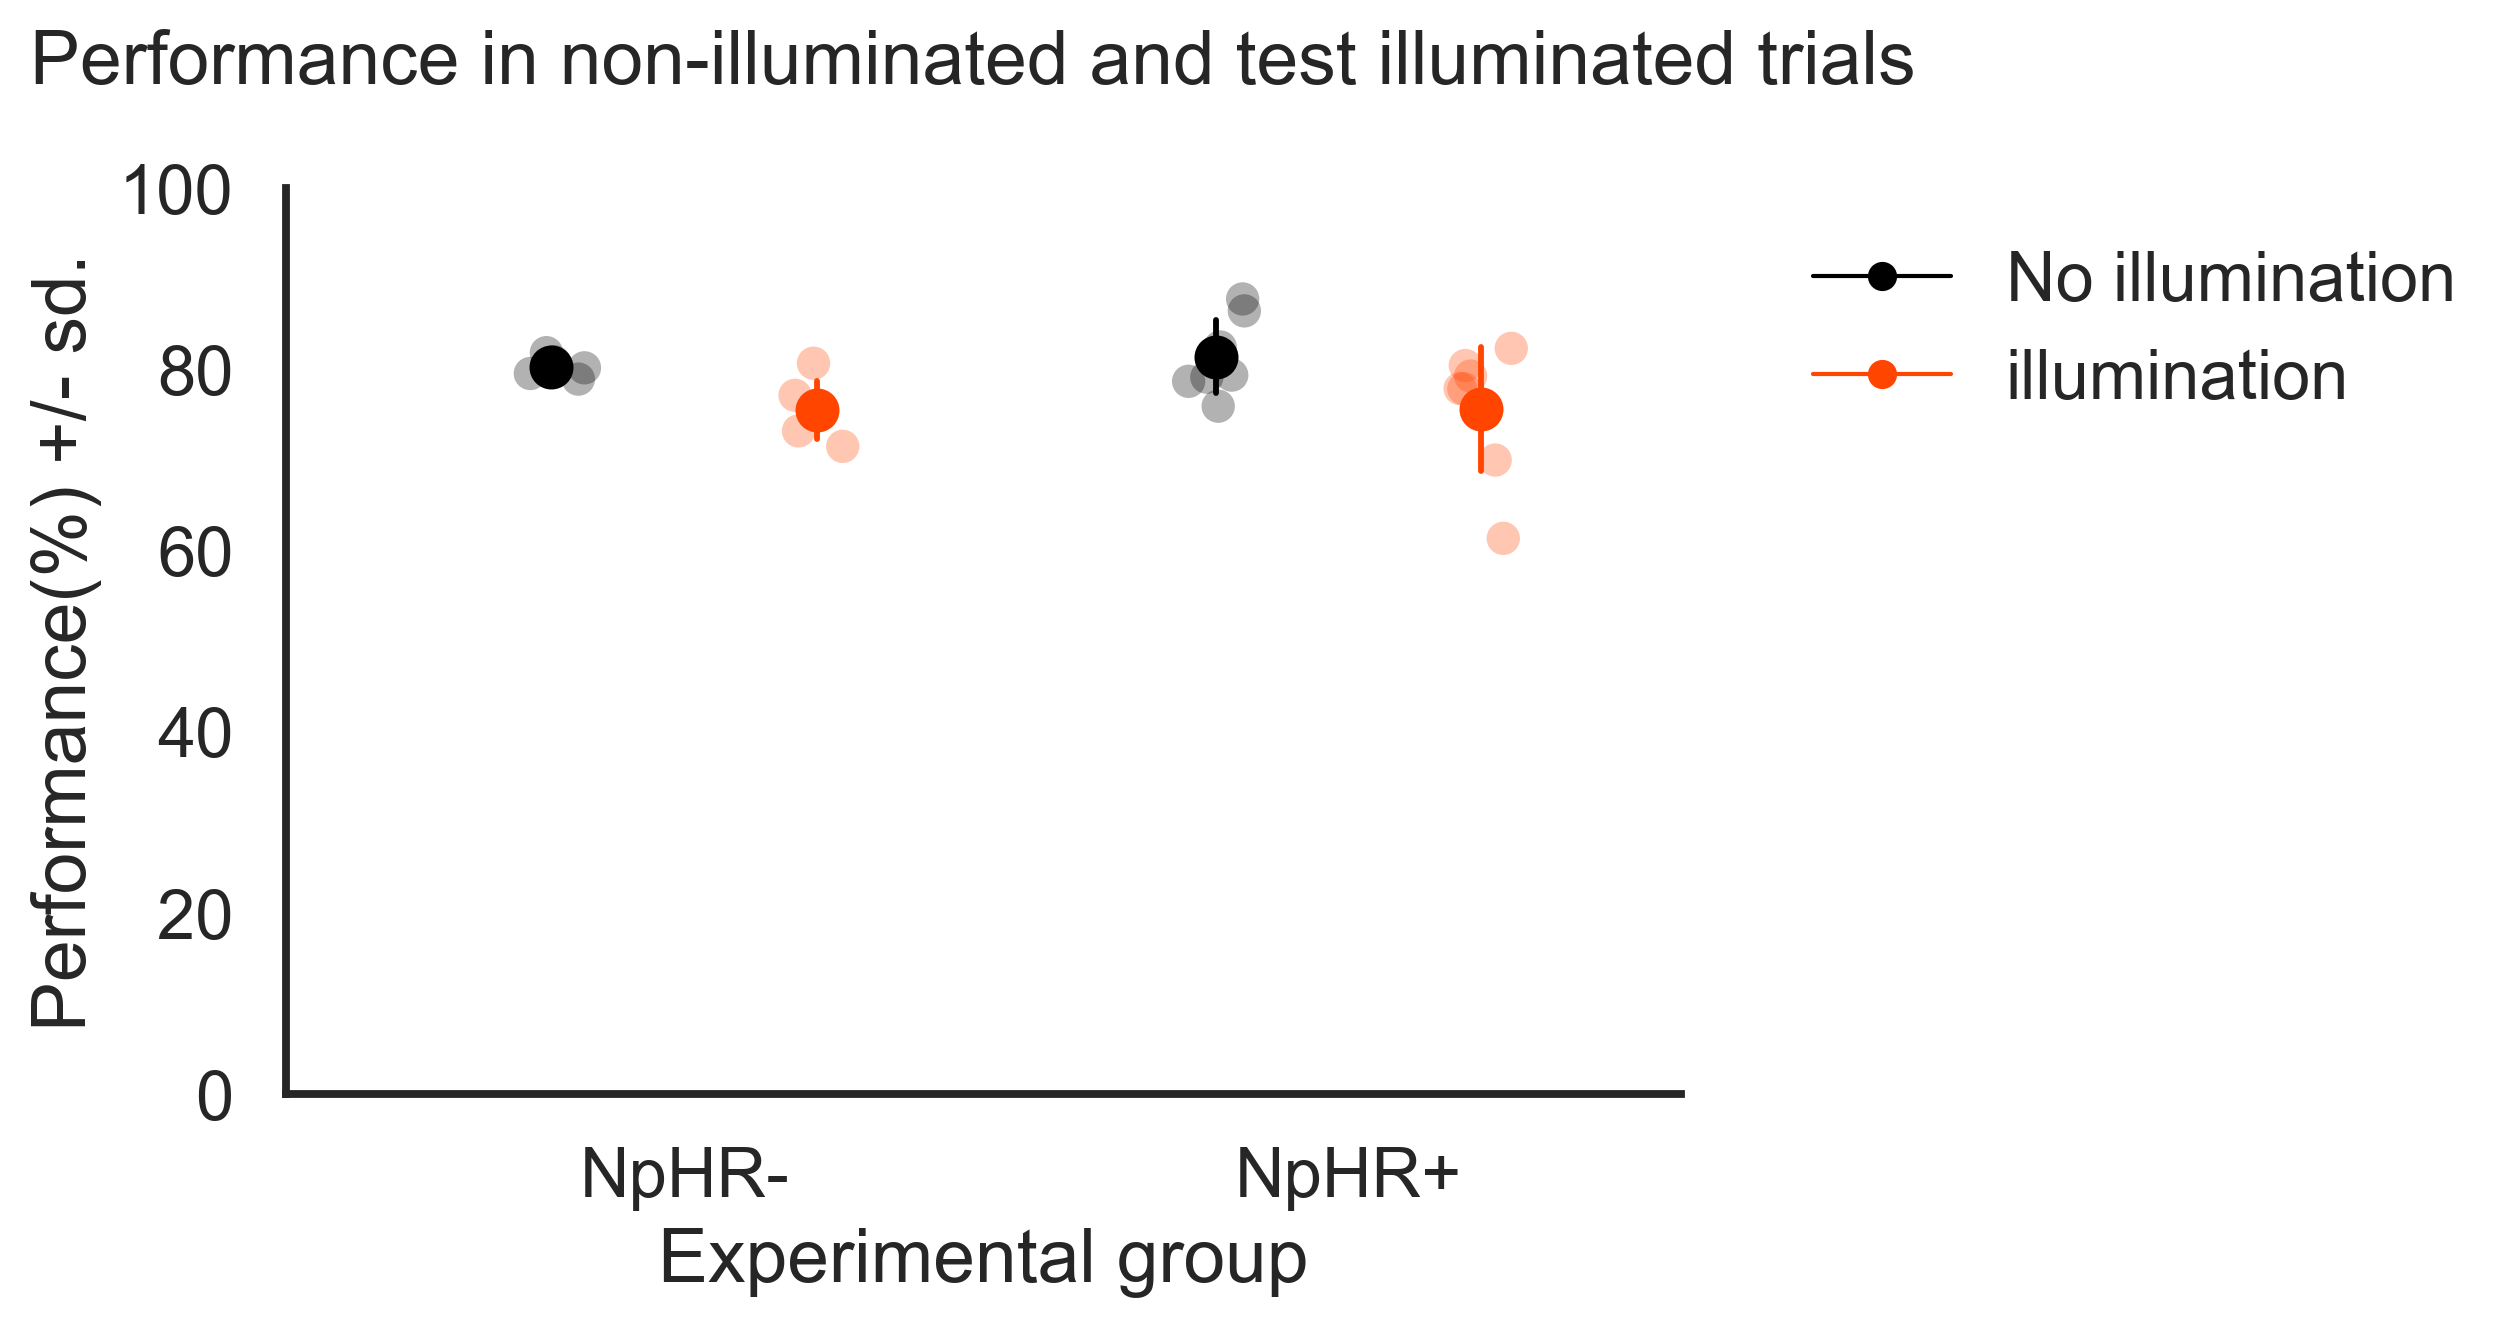

In [12]:
sns.set(style="white", context='talk')    
plt.figure(figsize=(6,4), dpi=300)

pooled_perfs['stim_condition'] = pooled_perfs['stim_condition'].astype(str)

g = sns.stripplot(
    x='group', y='performance', hue='stim_condition',
    data=pooled_perfs,
    dodge=2, jitter=.1,
    alpha=.3, s=8,
    palette=['black', 'orangered'],
    order=['CTRL', 'NPHR']
)

# Show means
sns.pointplot(
    x='group', y='performance', hue='stim_condition',
    data=pooled_perfs,
    dodge=.4, 
    join=False,            
    markers="o", scale=.8, 
    ci="sd", errwidth=1.4,
    palette=['black', 'orangered'],
    order=['CTRL', 'NPHR']
)

g.set(
    ylabel='Performance(%) +/- sd.', xlabel='Experimental group',
    ylim=(0, 100), xlim=(-0.6, 1.5),
    title='Performance in non-illuminated and test illuminated trials \n'
)

g.set_xticklabels(labels=['NpHR-', 'NpHR+'], rotation=0)

# ------------------------------------- LEGEND -------------------------------------------- 
g.legend_.remove()

control_line = mlines.Line2D([], [], color='black', marker='o', markersize=6, linewidth=1, label='No illumination')
nphr_line = mlines.Line2D([], [], color='orangered', marker='o', markersize=6, linewidth=1, label='illumination')
plt.legend(handles=[control_line, nphr_line], frameon=False, loc='upper right', bbox_to_anchor=(1.6, 1))
sns.despine()

### By now comparing the performances within the experimental groups and under different illumination conditions, we find that no decrease in performance is found in the NpHR- group - as predicted. However, we cannot find a decreased performance under illumination in the NpHR+ group. But how to different animals peform? And are the small variations in performance found under different illumination conditions always in the same direction (constitently a decrease or an increase)?

## <font color='darkgreen'> How does performance vary within each group, that is across individuals? And how much does it vary?

<Figure size 2700x1200 with 0 Axes>

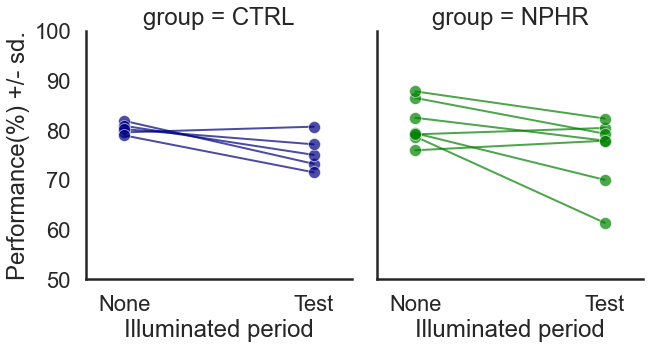

In [14]:
sns.set(style="white", context='poster')    
plt.figure(figsize=(9,4),dpi=300)
colors = ['navy']*5 + ['green']*7 # Needs adjusting as more rats are added
g = sns.relplot(
    data=pooled_perfs, col='group', height=5,
    x='stim_condition', y='performance', hue='rat', kind='line',
    linewidth=2, marker='o', markersize=12, alpha=.7, 
    palette=colors, legend=False,
    aspect=.9
)

g.set(
    ylabel='Performance(%) +/- sd.', xlabel='Illuminated period',
    ylim=(50, 100), xlim=(-0.2, 1.2), xticks=[0,1],
    xticklabels=['None', 'Test']
)

In [18]:
no_illumin = pooled_perfs[pooled_perfs['stim_condition']=='0'].reset_index(drop=True)
test_illumin = pooled_perfs[pooled_perfs['stim_condition']=='3'].reset_index(drop=True)
diff = test_illumin['performance']-no_illumin['performance']
pooled_perf_diffs = pd.concat([no_illumin[['group', 'rat']], diff], axis=1)
pooled_perf_diffs

,group,rat,performance
0,CTRL,CTRL2,1.135236
1,CTRL,CTRL3,-8.632275
2,CTRL,CTRL4,-5.835498
3,CTRL,CTRL5,-3.037306
4,CTRL,CTRL6,-7.420635
5,NPHR,NPHR1,-17.334394
6,NPHR,NPHR2,-9.375000
7,NPHR,NPHR4,1.291005
8,NPHR,NPHR5,-4.595960
9,NPHR,NPHR6,-7.189542


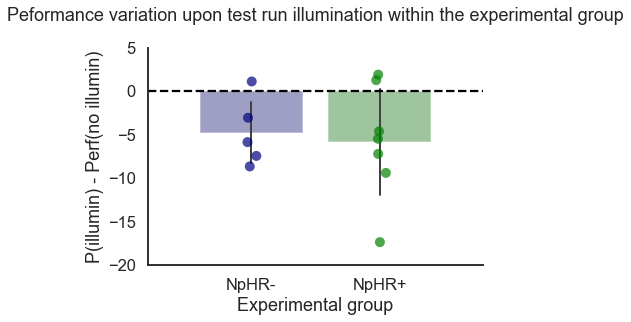

In [67]:
plt.Figure(figsize=(5,7))
sns.set(style='white', context='talk')

# Add bars
g = sns.barplot(data=pooled_perf_diffs, x='group', y='performance',
           ci='sd', errwidth=2,
            palette=['navy', 'green'], alpha=.4)
# Add individual dots
g = sns.stripplot(
    x='group', y='performance',
    data=pooled_perf_diffs,
    dodge=2, jitter=.05,b
    alpha=.7, s=10,
    palette=['navy', 'green'],
    order=['CTRL', 'NPHR']
)
# Add horizontal line (= zero deviation)
plt.axhline(0, 0, 2, linestyle='dashed', color='black')

# Add specs
g.set(ylabel='P(illumin) - Perf(no illumin)', xlabel='Experimental group',
     title='Peformance variation upon test run illumination within the experimental group\n',
     xticks=[0,1], xticklabels=['NpHR-', 'NpHR+'], xlim=[-.8,1.8], ylim=[-20, 5])

sns.despine()

#### As seen in both plots above, the variation of performance under different illumination conditions within each group is comparable, with similar average variation and with standard deviations overlaping. 

# <font color='darkgreen'> 2. Session performances distribution during the illumination protocol
***
   #### Calculation of the performances for each session*rat given the stimulation condition and grouped by experimental group
   #### Compares the performance levels of each experimental group in each stimulation condition, across the protocol, at the session level
***

In [75]:
session_perfs

,group,rat,session,stim_condition,performance
0,CTRL,CTRL2,2020-02-07T14_40_27,0,50.000000
1,CTRL,CTRL2,2020-02-07T14_40_27,3,71.428571
2,CTRL,CTRL2,2020-02-08T10_24_17,0,71.428571
3,CTRL,CTRL2,2020-02-08T10_24_17,3,100.000000
4,CTRL,CTRL2,2020-02-09T10_17_11,0,100.000000
...,...,...,...,...,...
352,NPHR,NPHR8,2020-12-02T14_09_52,3,77.777778
353,NPHR,NPHR8,2020-12-07T15_25_21,0,83.333333
354,NPHR,NPHR8,2020-12-07T15_25_21,3,85.714286
355,NPHR,NPHR8,2020-12-08T13_06_15,0,100.000000


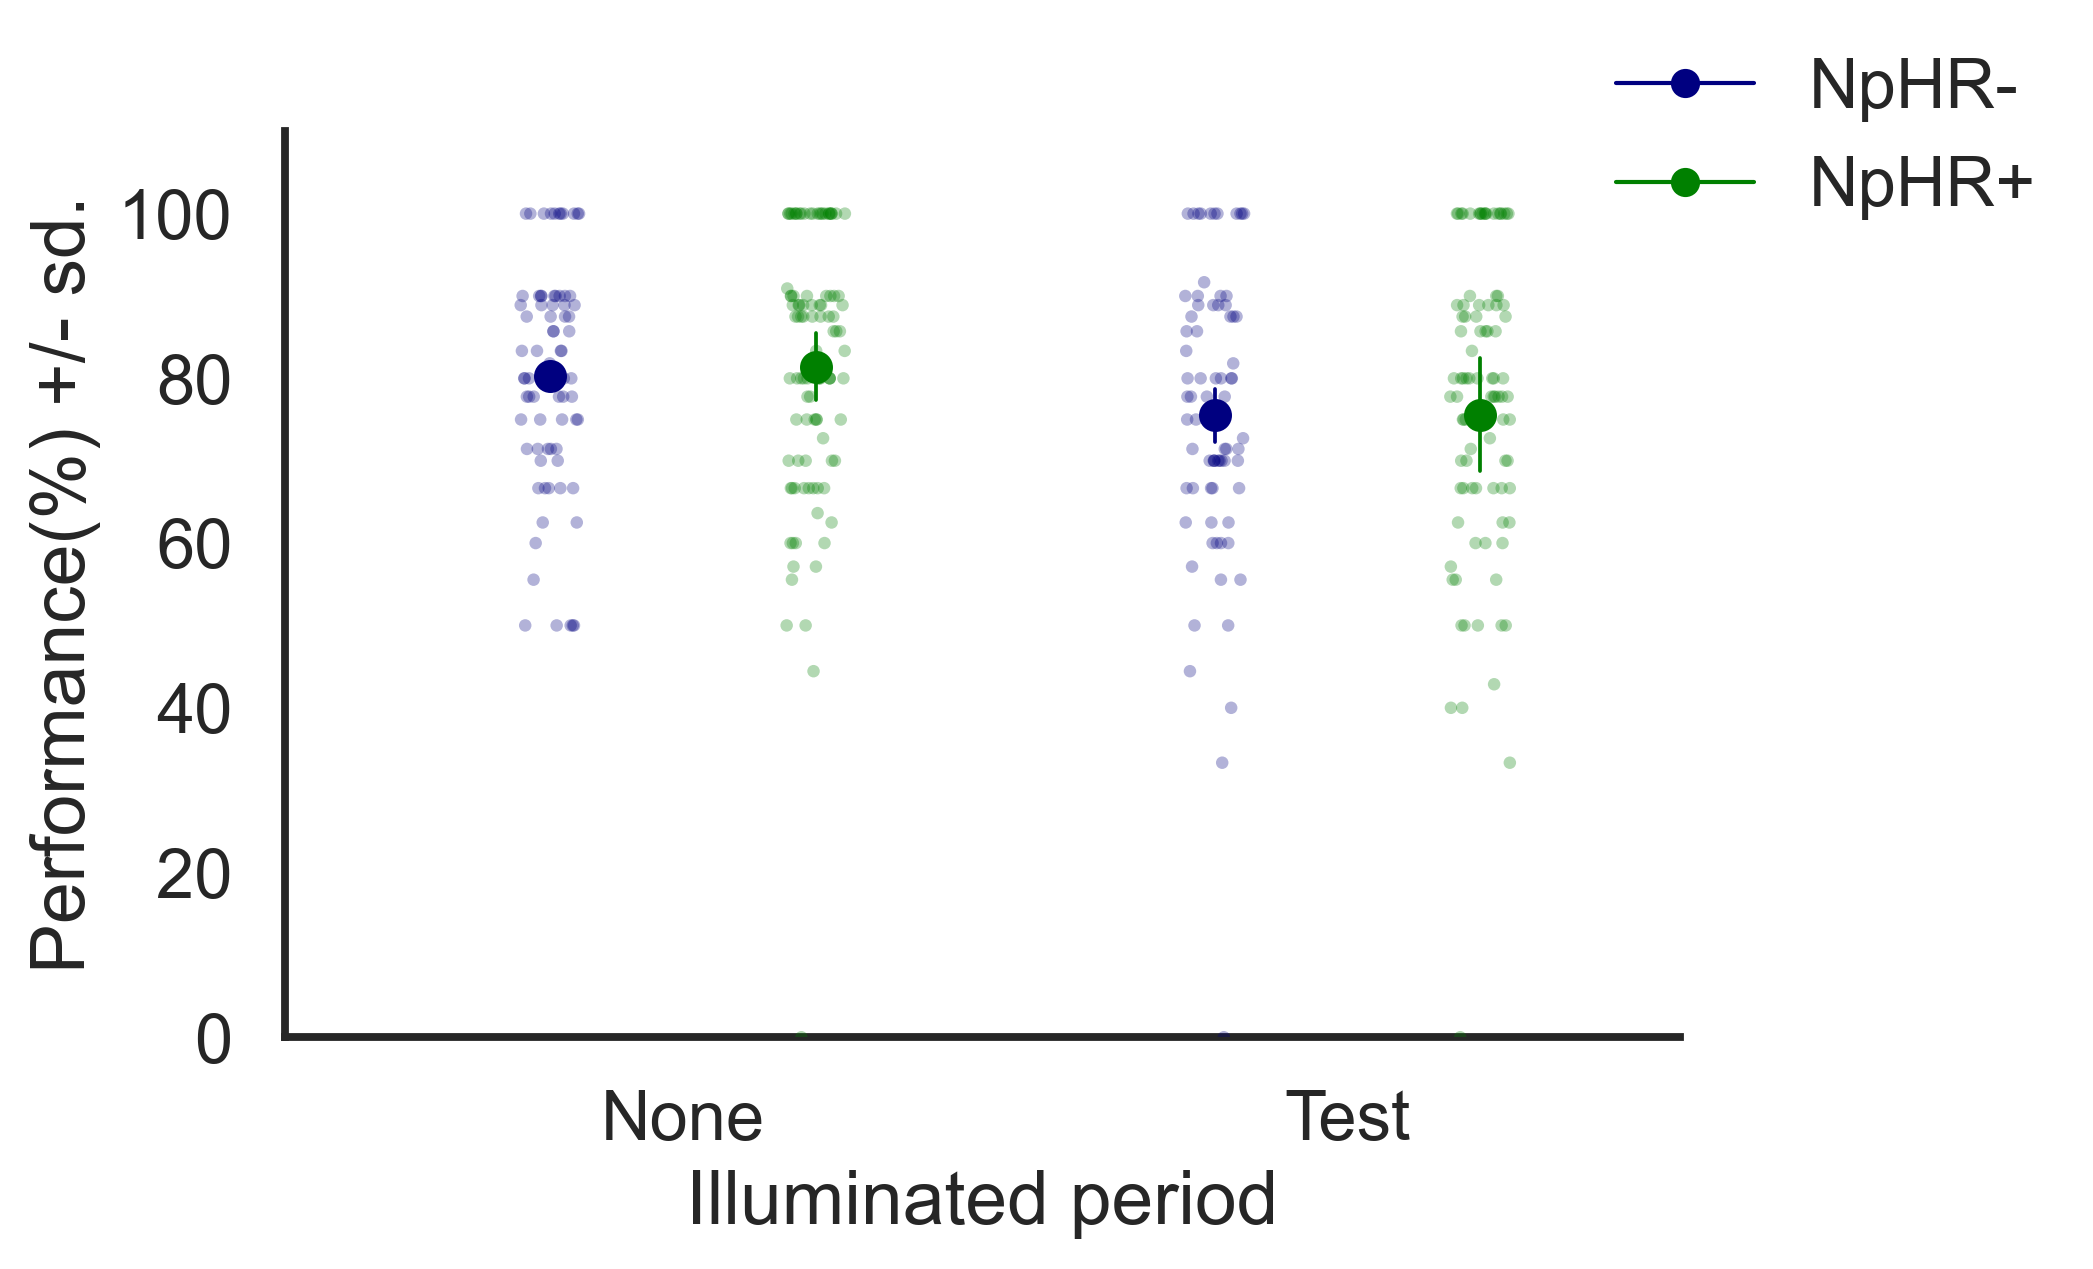

In [99]:
sns.set(style="white", context='talk')    
plt.figure(figsize=(6,4),dpi=300)
# Remove sessions with performance=0 - they were checked and are portions of sessions)
sessions_perfs = session_perfs[session_perfs['performance']!=0]
g = sns.stripplot(
    data=session_perfs,
    x='stim_condition', y='performance', hue='group',
    dodge=2, jitter=.09,
    alpha=.3, s=3,
    palette=['navy', 'green'],
    order=[0, 3]
)

# Show means
sns.pointplot(
    x='stim_condition', y='performance', hue='group',
    data=pooled_perfs,
    dodge=.4, 
    join=False,            
    markers="o", scale=.6, linewidth=1.5,
    ci="sd", errwidth=.9,
    palette=['navy', 'green'],
    order=['0', '3']
)
g.set(
    ylabel='Performance(%) +/- sd.', xlabel='Illuminated period',
    ylim=(0, 110), xlim=(-0.6, 1.5), xticklabels=['None', 'Test'])
# ------------------------------------- LEGEND -------------------------------------------- 
g.legend_.remove()
control_line = mlines.Line2D([], [], color='navy', marker='o', markersize=6, linewidth=1, label='NpHR-')
nphr_line = mlines.Line2D([], [], color='green', marker='o', markersize=6, linewidth=1, label='NpHR+')
plt.legend(handles=[control_line, nphr_line], frameon=False, loc='upper right', bbox_to_anchor=(1.3, 1.15))

sns.despine()

#### Some sessions (below) have a performance of zero. I checked these sessions and they are all small portions of larger sessions (for instance due to Bonsai crahes). Due to the low number of trials, it is easy for them to have performances of zero. 

# <font color='darkgreen'> 3. How does performance vary with experience?
***
#### Grouping trials by groups of 50 and calculating the performance under no illumination or test illumination in each group
***

In [103]:
# Calculate performance per condition at any given N trials

grouped = below15_test_runs.groupby(['group','rat', 'stim_condition'])
group_list = []

N = 50

for group in grouped.groups:
    
    par_perf_group = calculate_performance_given_ntrials(grouped, group, N)
    
    try:
        group_list.append(par_perf_group)
    except:
        group_list = par_perf_group
        
par_perf = pd.concat(group_list)
par_perf = par_perf.rename(columns={'outcome': 'performance'}).reset_index()

In [104]:
par_perf

,index,performance,group,rat,stim
0,0,76.000000,CTRL,CTRL2,0
1,1,84.000000,CTRL,CTRL2,0
2,2,73.684211,CTRL,CTRL2,0
3,0,78.000000,CTRL,CTRL2,3
4,1,80.000000,CTRL,CTRL2,3
...,...,...,...,...,...
61,1,90.000000,NPHR,NPHR8,0
62,2,86.666667,NPHR,NPHR8,0
63,0,82.000000,NPHR,NPHR8,3
64,1,80.000000,NPHR,NPHR8,3


['NPHR1' 'NPHR2' 'NPHR4' 'NPHR5' 'NPHR6' 'NPHR7' 'NPHR8']


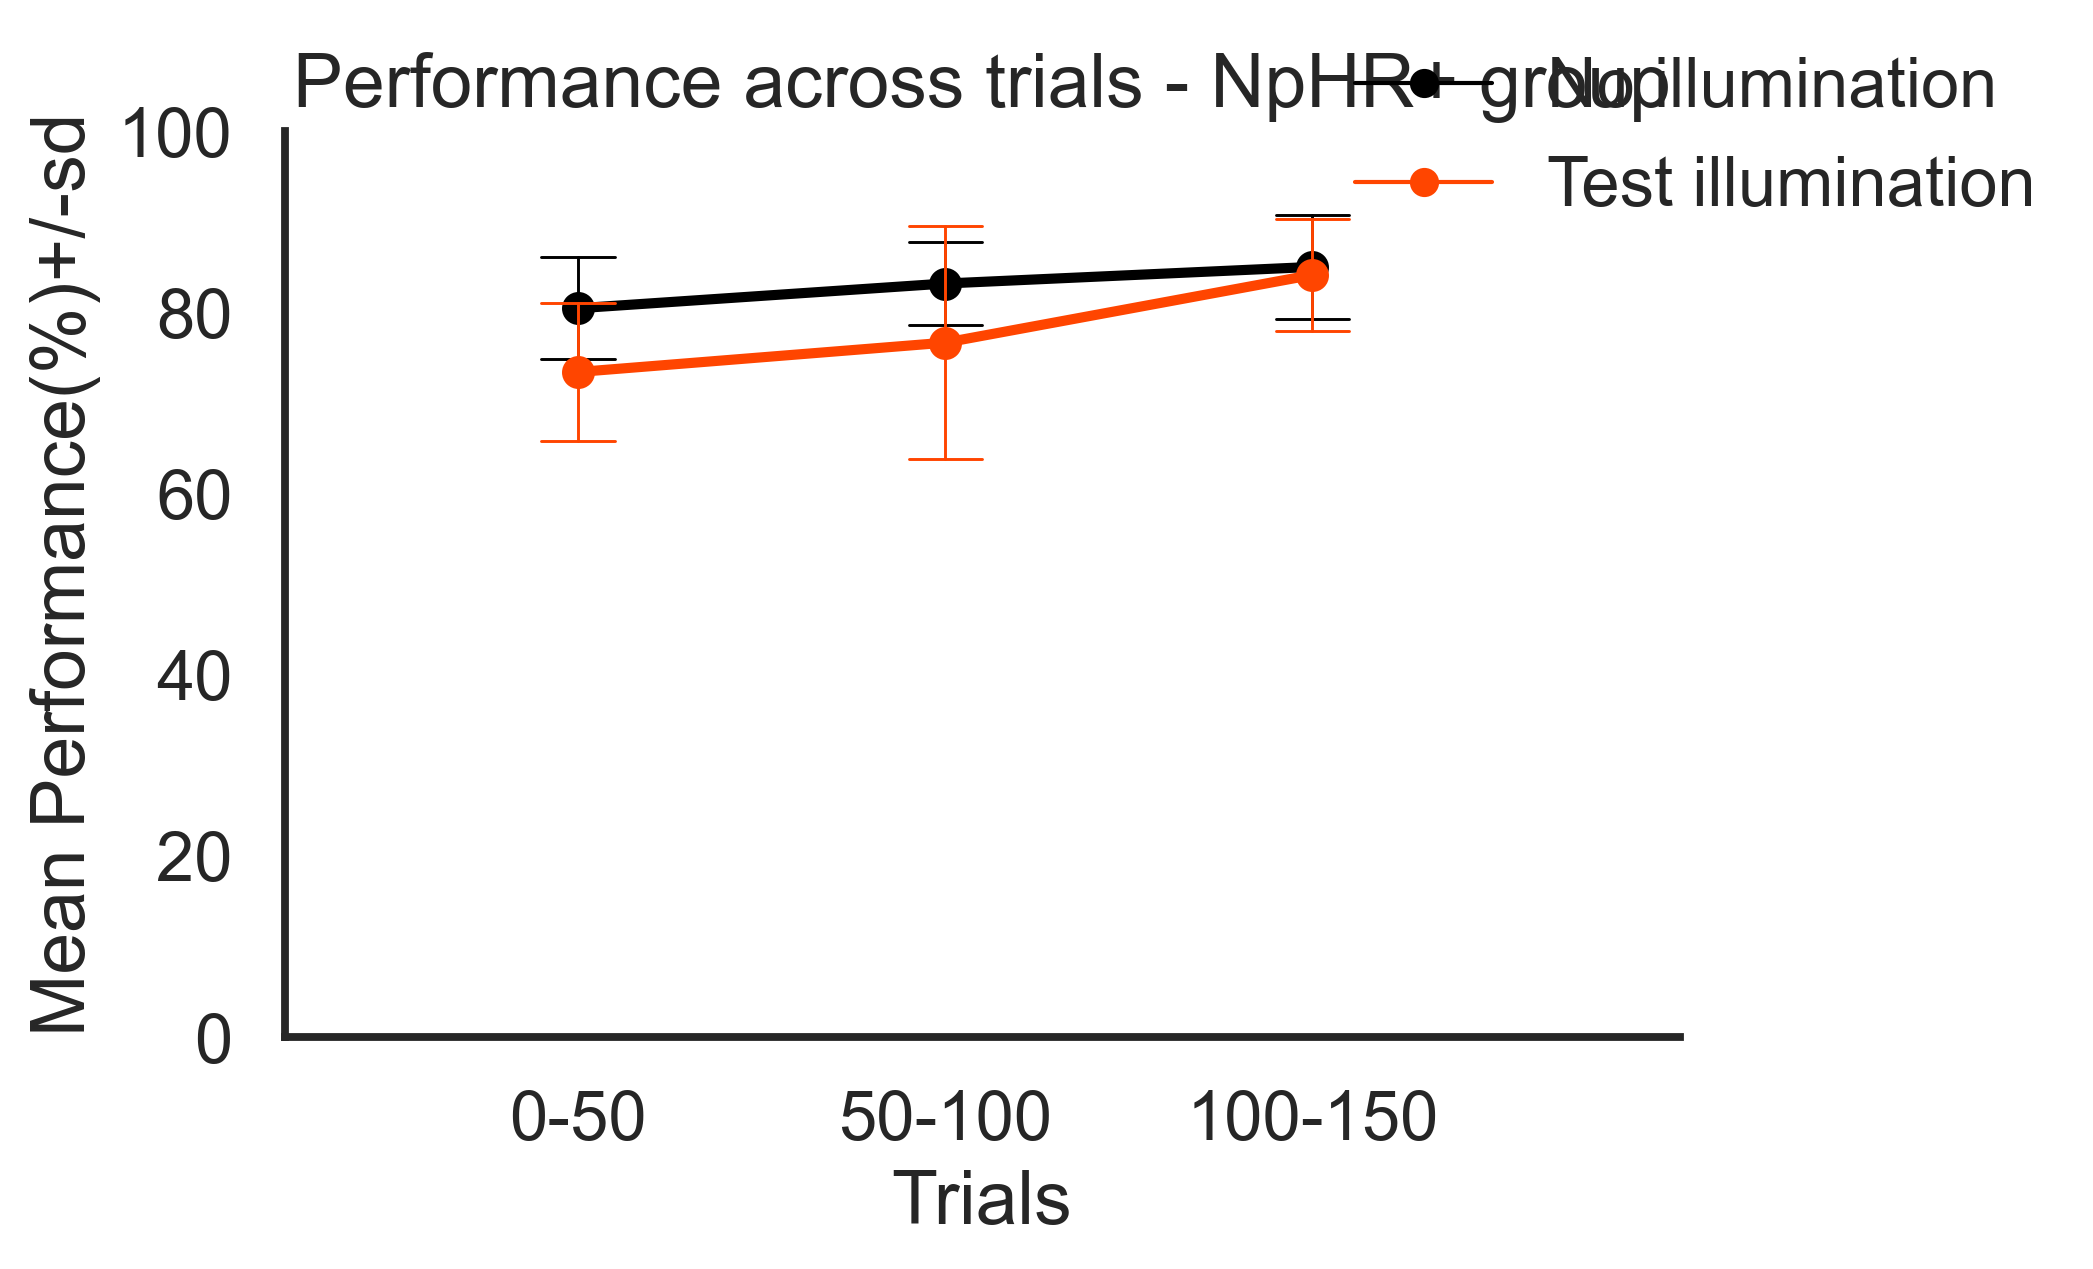

In [143]:
df = par_perf[par_perf['group'] == 'NPHR']

print(df['rat'].unique())

sns.set(style="white", context='talk')
plt.figure(figsize=(6,4), dpi=300)

#g = sns.stripplot(
#    data=df, x='index', y='performance', hue='stim',
#    jitter=.15, alpha=.7, s=4, dodge=True,
#    palette=['black', 'orangered']
#)
    
# Show means. 1st color=0, 3rd color=test
g=sns.pointplot(
    data=df, x='index', y='performance', hue='stim', 
    alpha=.3, scale=.6,linewidth=.5,
    ci='sd', errwidth=.7, capsize=.2, dodge=False,
    palette=['black', 'orangered']
)

g.set(
    xlim=(-.8,3), ylim=(0,100),
    ylabel=' Mean Performance(%)+/-sd', xlabel='Trials',
    title='Performance across trials - NpHR+ group'
)

g.set_xticklabels(['0-50', '50-100', '100-150'])
g.legend_.remove()
noillum_line = mlines.Line2D([], [], color='black', marker='o', markersize=6, linewidth=1, label='No illumination')
testillum_line = mlines.Line2D([], [], color='orangered', marker='o', markersize=6, linewidth=1, label='Test illumination')
plt.legend(handles=[noillum_line, testillum_line], frameon=False, loc='upper right', bbox_to_anchor=(1.3, 1.15))
sns.despine()